In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

C:\Users\Oladimeji\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = "Aurora Cannabis Inc Stock History.csv"
df = pd.read_csv(data)

In [3]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2-Oct-19,5.56,5.33,5.76,5.05,13.85M,2.21
1,1-Oct-19,5.44,5.75,5.83,5.36,11.89M,-6.53
2,30-Sep-19,5.82,6.05,6.09,5.74,6.54M,-4.90
3,27-Sep-19,6.12,6.21,6.40,6.10,4.38M,-3.16
4,26-Sep-19,6.32,6.48,6.50,6.21,2.70M,-0.16


In [4]:
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df.drop(["Vol.", "Change %"], axis =1, inplace= True)
df = df.sort_values('Date')
df.head(10)

,Date,Price,Open,High,Low
1257,2014-05-12,0.05,0.05,0.05,0.05
1256,2014-05-21,0.05,0.05,0.07,0.05
1255,2014-05-22,0.03,0.01,0.03,0.00
1254,2014-06-20,0.14,0.08,0.15,0.08
1253,2014-06-23,0.15,0.13,0.18,0.12
1252,2014-06-24,0.14,0.14,0.15,0.13
1251,2014-06-25,0.14,0.14,0.14,0.14
1250,2014-06-26,0.13,0.14,0.15,0.13
1249,2014-06-27,0.14,0.13,0.14,0.13
1248,2014-06-30,0.14,0.14,0.14,0.14


In [5]:
df.shape[0]

1258

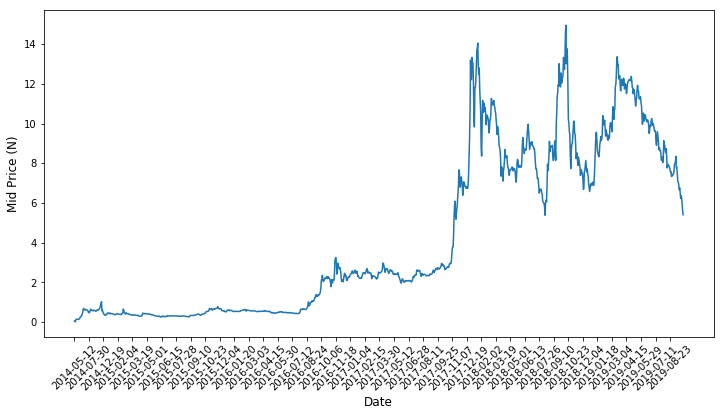

In [6]:
plt.figure(figsize = (12,6))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],30),df['Date'].loc[::30],rotation=45)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Mid Price (N)',fontsize=12)
plt.show()

In [7]:
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

C:\Users\Oladimeji\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\Oladimeji\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
split = 0.8
num_test_samples = int(split * mid_prices.shape[0])
train_data =  mid_prices[:num_test_samples]
test_data = mid_prices[num_test_samples:]

In [9]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [10]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 100
for di in range(0,400,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [11]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [12]:
EMA = 0.0
gamma = 0.1
for ti in range(num_test_samples):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [13]:
window_size = 10
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00114


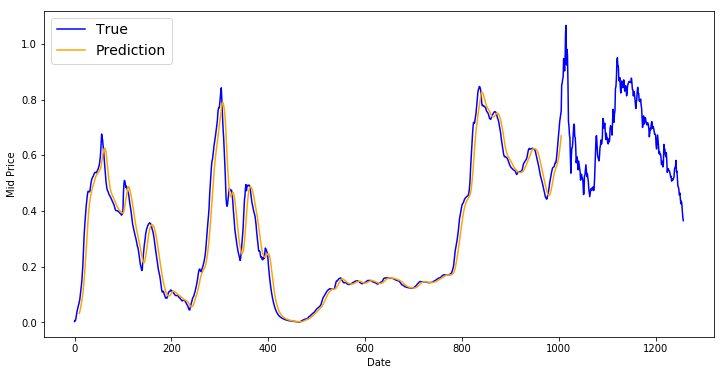

In [14]:
plt.figure(figsize = (12,6))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=14)
plt.show()

In [15]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
        
    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels
    
    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))

In [16]:
dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00346535 0.1140963  0.21450776 0.14390868 0.42001   ]

	Output: [0.00681683 0.11173839 0.17535128 0.14901803 0.42534843]


Unrolled index 1
	Inputs:  [0.00757426 0.11336628 0.19393772 0.14463708 0.42534843]

	Output: [0.00681683 0.10930242 0.15866019 0.14710465 0.44050077]


Unrolled index 2
	Inputs:  [0.00681683 0.11173839 0.17535128 0.1455495  0.4265567 ]

	Output: [0.03739521 0.1051369  0.12975879 0.1504832  0.43582654]


Unrolled index 3
	Inputs:  [0.01603614 0.10930242 0.15866019 0.14710465 0.43010288]

	Output: [0.04603193 0.09991817 0.11722328 0.1504832  0.43582654]


Unrolled index 4
	Inputs:  [0.02779886 0.10711004 0.14356482 0.14901803 0.43582654]

	Output: [0.03739521 0.1051369  0.10579453 0.15087584 0.44642398]


In [17]:
D = 1 
num_unrollings = 20 # Number of time steps you look into the future.
batch_size = 50 # Number of samples in a batch
num_nodes = [20,20,15] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [18]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [19]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


In [20]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [22]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [24]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 10 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(1000,1200,20).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

        # ============================ Validation ==============================
        if (ep+1) % valid_summary == 0:

            average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

        # The average loss
        if (ep+1)%valid_summary==0:
            print('Average loss at step %d: %f' % (ep+1, average_loss))

        train_mse_ot.append(average_loss)

        average_loss = 0 # reset loss

        predictions_seq = []

        mse_test_loss_seq = []

        # ===================== Updating State and Making Predicitons ========================
        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []

            if (ep+1)-valid_summary==0:
              # Only calculate x_axis values in the first validation epoch
              x_axis=[]
                
            # Feed in the recent past behavior of stock prices
            # to make predictions from that point onwards
            for tr_i in range(w_i-num_unrollings+1,w_i-1):
                current_price = all_mid_data[tr_i]
                feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
                _ = session.run(sample_prediction,feed_dict=feed_dict)

            feed_dict = {}

            current_price = all_mid_data[w_i-1]

            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
            
             # Make predictions for this many steps
             # Each prediction uses previous prediciton as it's current input
            for pred_i in range(n_predict_once):

                pred = session.run(sample_prediction,feed_dict=feed_dict)

                our_predictions.append(np.asscalar(pred))

                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)
                
                if (ep+1)-valid_summary==0:
                    # Only calculate x_axis values in the first validation epoch
                    x_axis.append(w_i+pred_i)

                mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

            session.run(reset_sample_states)

            predictions_seq.append(np.array(our_predictions))

            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)

            if (ep+1)-valid_summary==0:
                x_axis_seq.append(x_axis)
                
            current_test_mse = np.mean(mse_test_loss_seq)

            # Learning rate decay logic
            if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
                loss_nondecrease_count += 1
            else:
                loss_nondecrease_count = 0

            if loss_nondecrease_count > loss_nondecrease_threshold :
                session.run(inc_gstep)
                loss_nondecrease_count = 0
                print('\tDecreasing learning rate by 0.5')

            test_mse_ot.append(current_test_mse)
            print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
            predictions_over_time.append(predictions_seq)
            print('\tFinished Predictions')





C:\Users\Oladimeji\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 0.063415
	Test MSE: 0.30719
	Finished Predictions
	Test MSE: 0.26212
	Finished Predictions
	Test MSE: 0.22403
	Finished Predictions
	Test MSE: 0.19654
	Finished Predictions
	Test MSE: 0.19490
	Finished Predictions
	Test MSE: 0.20051
	Finished Predictions
	Test MSE: 0.22931
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24761
	Finished Predictions
	Test MSE: 0.25773
	Finished Predictions
	Test MSE: 0.25736
	Finished Predictions
Average loss at step 1: 0.070908
	Decreasing learning rate by 0.5
	Test MSE: 0.30618
	Finished Predictions
	Test MSE: 0.26105
	Finished Predictions
	Test MSE: 0.22308
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19567
	Finished Predictions
	Test MSE: 0.19406
	Finished Predictions
	Test MSE: 0.19964
	Finished Predictions
	Test MSE: 0.22838
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24662
	Finished Predictions
	Test MSE: 0.25670
	Finished Predictions
	Test MSE: 

	Test MSE: 0.22802
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24623
	Finished Predictions
	Test MSE: 0.25629
	Finished Predictions
	Test MSE: 0.25592
	Finished Predictions
Average loss at step 1: 0.069665
	Decreasing learning rate by 0.5
	Test MSE: 0.30576
	Finished Predictions
	Test MSE: 0.26062
	Finished Predictions
	Test MSE: 0.22268
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19532
	Finished Predictions
	Test MSE: 0.19371
	Finished Predictions
	Test MSE: 0.19929
	Finished Predictions
	Test MSE: 0.22800
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24621
	Finished Predictions
	Test MSE: 0.25627
	Finished Predictions
	Test MSE: 0.25590
	Finished Predictions
Average loss at step 1: 0.064847
	Decreasing learning rate by 0.5
	Test MSE: 0.30574
	Finished Predictions
	Test MSE: 0.26060
	Finished Predictions
	Test MSE: 0.22266
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19530
	Finished Prediction

Average loss at step 2: 0.072065
	Decreasing learning rate by 0.5
	Test MSE: 0.30545
	Finished Predictions
	Test MSE: 0.26029
	Finished Predictions
	Test MSE: 0.22239
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19505
	Finished Predictions
	Test MSE: 0.19345
	Finished Predictions
	Test MSE: 0.19903
	Finished Predictions
	Test MSE: 0.22771
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24591
	Finished Predictions
	Test MSE: 0.25596
	Finished Predictions
	Test MSE: 0.25559
	Finished Predictions
Average loss at step 2: 0.079112
	Decreasing learning rate by 0.5
	Test MSE: 0.30543
	Finished Predictions
	Test MSE: 0.26027
	Finished Predictions
	Test MSE: 0.22237
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19503
	Finished Predictions
	Test MSE: 0.19343
	Finished Predictions
	Test MSE: 0.19901
	Finished Predictions
	Test MSE: 0.22770
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24589
	Finished Prediction

	Test MSE: 0.19876
	Finished Predictions
	Test MSE: 0.22743
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24560
	Finished Predictions
	Test MSE: 0.25564
	Finished Predictions
	Test MSE: 0.25527
	Finished Predictions
Average loss at step 3: 0.062725
	Decreasing learning rate by 0.5
	Test MSE: 0.30513
	Finished Predictions
	Test MSE: 0.25995
	Finished Predictions
	Test MSE: 0.22208
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19477
	Finished Predictions
	Test MSE: 0.19317
	Finished Predictions
	Test MSE: 0.19874
	Finished Predictions
	Test MSE: 0.22741
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24558
	Finished Predictions
	Test MSE: 0.25562
	Finished Predictions
	Test MSE: 0.25525
	Finished Predictions
Average loss at step 3: 0.079661
	Decreasing learning rate by 0.5
	Test MSE: 0.30510
	Finished Predictions
	Test MSE: 0.25992
	Finished Predictions
	Test MSE: 0.22206
	Finished Predictions
	Decreasing learning rate by 0.

	Decreasing learning rate by 0.5
	Test MSE: 0.24530
	Finished Predictions
	Test MSE: 0.25533
	Finished Predictions
	Test MSE: 0.25495
	Finished Predictions
Average loss at step 4: 0.064733
	Decreasing learning rate by 0.5
	Test MSE: 0.30482
	Finished Predictions
	Test MSE: 0.25962
	Finished Predictions
	Test MSE: 0.22179
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19451
	Finished Predictions
	Test MSE: 0.19292
	Finished Predictions
	Test MSE: 0.19848
	Finished Predictions
	Test MSE: 0.22713
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24528
	Finished Predictions
	Test MSE: 0.25531
	Finished Predictions
	Test MSE: 0.25493
	Finished Predictions
Average loss at step 4: 0.070423
	Decreasing learning rate by 0.5
	Test MSE: 0.30480
	Finished Predictions
	Test MSE: 0.25960
	Finished Predictions
	Test MSE: 0.22177
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19449
	Finished Predictions
	Test MSE: 0.19290
	Finished Prediction

	Test MSE: 0.25465
	Finished Predictions
Average loss at step 4: 0.105048
	Decreasing learning rate by 0.5
	Test MSE: 0.30452
	Finished Predictions
	Test MSE: 0.25931
	Finished Predictions
	Test MSE: 0.22150
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19425
	Finished Predictions
	Test MSE: 0.19267
	Finished Predictions
	Test MSE: 0.19822
	Finished Predictions
	Test MSE: 0.22685
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24498
	Finished Predictions
	Test MSE: 0.25500
	Finished Predictions
	Test MSE: 0.25462
	Finished Predictions
Average loss at step 4: 0.107199
	Decreasing learning rate by 0.5
	Test MSE: 0.30450
	Finished Predictions
	Test MSE: 0.25928
	Finished Predictions
	Test MSE: 0.22148
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19423
	Finished Predictions
	Test MSE: 0.19265
	Finished Predictions
	Test MSE: 0.19821
	Finished Predictions
	Test MSE: 0.22683
	Finished Predictions
	Decreasing learning rate by 0.

	Test MSE: 0.25898
	Finished Predictions
	Test MSE: 0.22121
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19398
	Finished Predictions
	Test MSE: 0.19241
	Finished Predictions
	Test MSE: 0.19796
	Finished Predictions
	Test MSE: 0.22656
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24468
	Finished Predictions
	Test MSE: 0.25469
	Finished Predictions
	Test MSE: 0.25431
	Finished Predictions
Average loss at step 5: 0.066731
	Decreasing learning rate by 0.5
	Test MSE: 0.30419
	Finished Predictions
	Test MSE: 0.25896
	Finished Predictions
	Test MSE: 0.22119
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19397
	Finished Predictions
	Test MSE: 0.19239
	Finished Predictions
	Test MSE: 0.19794
	Finished Predictions
	Test MSE: 0.22654
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24466
	Finished Predictions
	Test MSE: 0.25466
	Finished Predictions
	Test MSE: 0.25429
	Finished Predictions
Average loss at step 5:

	Test MSE: 0.19770
	Finished Predictions
	Test MSE: 0.22628
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24438
	Finished Predictions
	Test MSE: 0.25437
	Finished Predictions
	Test MSE: 0.25399
	Finished Predictions
Average loss at step 6: 0.054273
	Decreasing learning rate by 0.5
	Test MSE: 0.30388
	Finished Predictions
	Test MSE: 0.25864
	Finished Predictions
	Test MSE: 0.22090
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19370
	Finished Predictions
	Test MSE: 0.19213
	Finished Predictions
	Test MSE: 0.19768
	Finished Predictions
	Test MSE: 0.22626
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24436
	Finished Predictions
	Test MSE: 0.25435
	Finished Predictions
	Test MSE: 0.25397
	Finished Predictions
Average loss at step 6: 0.050562
	Decreasing learning rate by 0.5
	Test MSE: 0.30386
	Finished Predictions
	Test MSE: 0.25861
	Finished Predictions
	Test MSE: 0.22088
	Finished Predictions
	Decreasing learning rate by 0.

Average loss at step 7: 0.085540
	Decreasing learning rate by 0.5
	Test MSE: 0.30358
	Finished Predictions
	Test MSE: 0.25832
	Finished Predictions
	Test MSE: 0.22062
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19345
	Finished Predictions
	Test MSE: 0.19188
	Finished Predictions
	Test MSE: 0.19743
	Finished Predictions
	Test MSE: 0.22599
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24406
	Finished Predictions
	Test MSE: 0.25405
	Finished Predictions
	Test MSE: 0.25367
	Finished Predictions
Average loss at step 7: 0.092416
	Decreasing learning rate by 0.5
	Test MSE: 0.30356
	Finished Predictions
	Test MSE: 0.25830
	Finished Predictions
	Test MSE: 0.22060
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19343
	Finished Predictions
	Test MSE: 0.19187
	Finished Predictions
	Test MSE: 0.19741
	Finished Predictions
	Test MSE: 0.22597
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24405
	Finished Prediction

	Test MSE: 0.19716
	Finished Predictions
	Test MSE: 0.22570
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24376
	Finished Predictions
	Test MSE: 0.25374
	Finished Predictions
	Test MSE: 0.25335
	Finished Predictions
Average loss at step 7: 0.076786
	Decreasing learning rate by 0.5
	Test MSE: 0.30326
	Finished Predictions
	Test MSE: 0.25798
	Finished Predictions
	Test MSE: 0.22031
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19317
	Finished Predictions
	Test MSE: 0.19161
	Finished Predictions
	Test MSE: 0.19715
	Finished Predictions
	Test MSE: 0.22568
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24374
	Finished Predictions
	Test MSE: 0.25371
	Finished Predictions
	Test MSE: 0.25333
	Finished Predictions
Average loss at step 8: 0.086297
	Decreasing learning rate by 0.5
	Test MSE: 0.30324
	Finished Predictions
	Test MSE: 0.25796
	Finished Predictions
	Test MSE: 0.22029
	Finished Predictions
	Decreasing learning rate by 0.

Average loss at step 8: 0.056519
	Decreasing learning rate by 0.5
	Test MSE: 0.30295
	Finished Predictions
	Test MSE: 0.25766
	Finished Predictions
	Test MSE: 0.22002
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19291
	Finished Predictions
	Test MSE: 0.19136
	Finished Predictions
	Test MSE: 0.19689
	Finished Predictions
	Test MSE: 0.22540
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24344
	Finished Predictions
	Test MSE: 0.25340
	Finished Predictions
	Test MSE: 0.25302
	Finished Predictions
Average loss at step 8: 0.050265
	Decreasing learning rate by 0.5
	Test MSE: 0.30293
	Finished Predictions
	Test MSE: 0.25764
	Finished Predictions
	Test MSE: 0.22000
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19289
	Finished Predictions
	Test MSE: 0.19134
	Finished Predictions
	Test MSE: 0.19687
	Finished Predictions
	Test MSE: 0.22538
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24342
	Finished Prediction

	Test MSE: 0.19663
	Finished Predictions
	Test MSE: 0.22513
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24315
	Finished Predictions
	Test MSE: 0.25310
	Finished Predictions
	Test MSE: 0.25272
	Finished Predictions
Average loss at step 9: 0.095515
	Decreasing learning rate by 0.5
	Test MSE: 0.30263
	Finished Predictions
	Test MSE: 0.25732
	Finished Predictions
	Test MSE: 0.21972
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19264
	Finished Predictions
	Test MSE: 0.19109
	Finished Predictions
	Test MSE: 0.19662
	Finished Predictions
	Test MSE: 0.22511
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24313
	Finished Predictions
	Test MSE: 0.25308
	Finished Predictions
	Test MSE: 0.25269
	Finished Predictions
Average loss at step 9: 0.092055
	Decreasing learning rate by 0.5
	Test MSE: 0.30261
	Finished Predictions
	Test MSE: 0.25730
	Finished Predictions
	Test MSE: 0.21970
	Finished Predictions
	Decreasing learning rate by 0.

Average loss at step 10: 0.092077
	Decreasing learning rate by 0.5
	Test MSE: 0.30233
	Finished Predictions
	Test MSE: 0.25700
	Finished Predictions
	Test MSE: 0.21943
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19237
	Finished Predictions
	Test MSE: 0.19083
	Finished Predictions
	Test MSE: 0.19635
	Finished Predictions
	Test MSE: 0.22483
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24283
	Finished Predictions
	Test MSE: 0.25277
	Finished Predictions
	Test MSE: 0.25238
	Finished Predictions
Average loss at step 10: 0.091336
	Decreasing learning rate by 0.5
	Test MSE: 0.30230
	Finished Predictions
	Test MSE: 0.25698
	Finished Predictions
	Test MSE: 0.21941
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19235
	Finished Predictions
	Test MSE: 0.19082
	Finished Predictions
	Test MSE: 0.19633
	Finished Predictions
	Test MSE: 0.22481
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24281
	Finished Predicti

	Decreasing learning rate by 0.5
	Test MSE: 0.19211
	Finished Predictions
	Test MSE: 0.19058
	Finished Predictions
	Test MSE: 0.19609
	Finished Predictions
	Test MSE: 0.22454
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24253
	Finished Predictions
	Test MSE: 0.25245
	Finished Predictions
	Test MSE: 0.25206
	Finished Predictions
Average loss at step 11: 0.058025
	Decreasing learning rate by 0.5
	Test MSE: 0.30200
	Finished Predictions
	Test MSE: 0.25666
	Finished Predictions
	Test MSE: 0.21912
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19209
	Finished Predictions
	Test MSE: 0.19056
	Finished Predictions
	Test MSE: 0.19608
	Finished Predictions
	Test MSE: 0.22453
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24251
	Finished Predictions
	Test MSE: 0.25243
	Finished Predictions
	Test MSE: 0.25204
	Finished Predictions
Average loss at step 11: 0.060418
	Decreasing learning rate by 0.5
	Test MSE: 0.30198
	Finished Predicti

	Test MSE: 0.22427
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24224
	Finished Predictions
	Test MSE: 0.25215
	Finished Predictions
	Test MSE: 0.25176
	Finished Predictions
Average loss at step 11: 0.070570
	Decreasing learning rate by 0.5
	Test MSE: 0.30170
	Finished Predictions
	Test MSE: 0.25634
	Finished Predictions
	Test MSE: 0.21883
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19184
	Finished Predictions
	Test MSE: 0.19031
	Finished Predictions
	Test MSE: 0.19582
	Finished Predictions
	Test MSE: 0.22425
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24222
	Finished Predictions
	Test MSE: 0.25213
	Finished Predictions
	Test MSE: 0.25174
	Finished Predictions
Average loss at step 11: 0.070611
	Decreasing learning rate by 0.5
	Test MSE: 0.30168
	Finished Predictions
	Test MSE: 0.25632
	Finished Predictions
	Test MSE: 0.21882
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19182
	Finished Predicti

	Decreasing learning rate by 0.5
	Test MSE: 0.30140
	Finished Predictions
	Test MSE: 0.25602
	Finished Predictions
	Test MSE: 0.21855
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19158
	Finished Predictions
	Test MSE: 0.19006
	Finished Predictions
	Test MSE: 0.19556
	Finished Predictions
	Test MSE: 0.22397
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24192
	Finished Predictions
	Test MSE: 0.25182
	Finished Predictions
	Test MSE: 0.25143
	Finished Predictions
Average loss at step 12: 0.069797
	Decreasing learning rate by 0.5
	Test MSE: 0.30138
	Finished Predictions
	Test MSE: 0.25600
	Finished Predictions
	Test MSE: 0.21853
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19156
	Finished Predictions
	Test MSE: 0.19004
	Finished Predictions
	Test MSE: 0.19554
	Finished Predictions
	Test MSE: 0.22395
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24190
	Finished Predictions
	Test MSE: 0.25180
	Finished P

	Test MSE: 0.21826
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19132
	Finished Predictions
	Test MSE: 0.18980
	Finished Predictions
	Test MSE: 0.19530
	Finished Predictions
	Test MSE: 0.22369
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24162
	Finished Predictions
	Test MSE: 0.25151
	Finished Predictions
	Test MSE: 0.25111
	Finished Predictions
Average loss at step 13: 0.077218
	Decreasing learning rate by 0.5
	Test MSE: 0.30107
	Finished Predictions
	Test MSE: 0.25568
	Finished Predictions
	Test MSE: 0.21824
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19130
	Finished Predictions
	Test MSE: 0.18979
	Finished Predictions
	Test MSE: 0.19528
	Finished Predictions
	Test MSE: 0.22367
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24160
	Finished Predictions
	Test MSE: 0.25149
	Finished Predictions
	Test MSE: 0.25109
	Finished Predictions
Average loss at step 13: 0.086663
	Decreasing learning rate by 

	Test MSE: 0.19504
	Finished Predictions
	Test MSE: 0.22341
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24132
	Finished Predictions
	Test MSE: 0.25120
	Finished Predictions
	Test MSE: 0.25080
	Finished Predictions
Average loss at step 14: 0.078152
	Decreasing learning rate by 0.5
	Test MSE: 0.30077
	Finished Predictions
	Test MSE: 0.25536
	Finished Predictions
	Test MSE: 0.21795
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19104
	Finished Predictions
	Test MSE: 0.18953
	Finished Predictions
	Test MSE: 0.19502
	Finished Predictions
	Test MSE: 0.22339
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24130
	Finished Predictions
	Test MSE: 0.25118
	Finished Predictions
	Test MSE: 0.25078
	Finished Predictions
Average loss at step 14: 0.091259
	Decreasing learning rate by 0.5
	Test MSE: 0.30075
	Finished Predictions
	Test MSE: 0.25534
	Finished Predictions
	Test MSE: 0.21793
	Finished Predictions
	Decreasing learning rate by 

Average loss at step 14: 0.088820
	Decreasing learning rate by 0.5
	Test MSE: 0.30046
	Finished Predictions
	Test MSE: 0.25504
	Finished Predictions
	Test MSE: 0.21766
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19078
	Finished Predictions
	Test MSE: 0.18928
	Finished Predictions
	Test MSE: 0.19476
	Finished Predictions
	Test MSE: 0.22311
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24100
	Finished Predictions
	Test MSE: 0.25087
	Finished Predictions
	Test MSE: 0.25047
	Finished Predictions
Average loss at step 14: 0.079485
	Decreasing learning rate by 0.5
	Test MSE: 0.30044
	Finished Predictions
	Test MSE: 0.25502
	Finished Predictions
	Test MSE: 0.21764
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19076
	Finished Predictions
	Test MSE: 0.18926
	Finished Predictions
	Test MSE: 0.19475
	Finished Predictions
	Test MSE: 0.22309
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24098
	Finished Predicti

	Test MSE: 0.21737
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19052
	Finished Predictions
	Test MSE: 0.18902
	Finished Predictions
	Test MSE: 0.19450
	Finished Predictions
	Test MSE: 0.22283
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24070
	Finished Predictions
	Test MSE: 0.25055
	Finished Predictions
	Test MSE: 0.25015
	Finished Predictions
Average loss at step 15: 0.051387
	Decreasing learning rate by 0.5
	Test MSE: 0.30014
	Finished Predictions
	Test MSE: 0.25470
	Finished Predictions
	Test MSE: 0.21735
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19050
	Finished Predictions
	Test MSE: 0.18901
	Finished Predictions
	Test MSE: 0.19448
	Finished Predictions
	Test MSE: 0.22281
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24068
	Finished Predictions
	Test MSE: 0.25053
	Finished Predictions
	Test MSE: 0.25013
	Finished Predictions
Average loss at step 15: 0.054574
	Decreasing learning rate by 

	Test MSE: 0.22255
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24040
	Finished Predictions
	Test MSE: 0.25025
	Finished Predictions
	Test MSE: 0.24985
	Finished Predictions
Average loss at step 16: 0.073774
	Decreasing learning rate by 0.5
	Test MSE: 0.29984
	Finished Predictions
	Test MSE: 0.25438
	Finished Predictions
	Test MSE: 0.21707
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19024
	Finished Predictions
	Test MSE: 0.18876
	Finished Predictions
	Test MSE: 0.19423
	Finished Predictions
	Test MSE: 0.22253
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24038
	Finished Predictions
	Test MSE: 0.25023
	Finished Predictions
	Test MSE: 0.24983
	Finished Predictions
Average loss at step 16: 0.069099
	Decreasing learning rate by 0.5
	Test MSE: 0.29982
	Finished Predictions
	Test MSE: 0.25436
	Finished Predictions
	Test MSE: 0.21705
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.19023
	Finished Predicti

	Decreasing learning rate by 0.5
	Test MSE: 0.29954
	Finished Predictions
	Test MSE: 0.25407
	Finished Predictions
	Test MSE: 0.21679
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18999
	Finished Predictions
	Test MSE: 0.18851
	Finished Predictions
	Test MSE: 0.19397
	Finished Predictions
	Test MSE: 0.22225
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24009
	Finished Predictions
	Test MSE: 0.24992
	Finished Predictions
	Test MSE: 0.24952
	Finished Predictions
Average loss at step 17: 0.098684
	Decreasing learning rate by 0.5
	Test MSE: 0.29952
	Finished Predictions
	Test MSE: 0.25404
	Finished Predictions
	Test MSE: 0.21677
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18997
	Finished Predictions
	Test MSE: 0.18849
	Finished Predictions
	Test MSE: 0.19396
	Finished Predictions
	Test MSE: 0.22224
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.24007
	Finished Predictions
	Test MSE: 0.24990
	Finished P

	Test MSE: 0.21650
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18973
	Finished Predictions
	Test MSE: 0.18825
	Finished Predictions
	Test MSE: 0.19371
	Finished Predictions
	Test MSE: 0.22197
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23979
	Finished Predictions
	Test MSE: 0.24961
	Finished Predictions
	Test MSE: 0.24921
	Finished Predictions
Average loss at step 17: 0.091351
	Decreasing learning rate by 0.5
	Test MSE: 0.29921
	Finished Predictions
	Test MSE: 0.25372
	Finished Predictions
	Test MSE: 0.21648
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18971
	Finished Predictions
	Test MSE: 0.18824
	Finished Predictions
	Test MSE: 0.19370
	Finished Predictions
	Test MSE: 0.22195
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23977
	Finished Predictions
	Test MSE: 0.24959
	Finished Predictions
	Test MSE: 0.24919
	Finished Predictions
Average loss at step 18: 0.079341
	Decreasing learning rate by 

	Test MSE: 0.22170
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23949
	Finished Predictions
	Test MSE: 0.24931
	Finished Predictions
	Test MSE: 0.24890
	Finished Predictions
Average loss at step 18: 0.058412
	Decreasing learning rate by 0.5
	Test MSE: 0.29891
	Finished Predictions
	Test MSE: 0.25341
	Finished Predictions
	Test MSE: 0.21620
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18945
	Finished Predictions
	Test MSE: 0.18799
	Finished Predictions
	Test MSE: 0.19344
	Finished Predictions
	Test MSE: 0.22168
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23948
	Finished Predictions
	Test MSE: 0.24929
	Finished Predictions
	Test MSE: 0.24888
	Finished Predictions
Average loss at step 18: 0.062420
	Decreasing learning rate by 0.5
	Test MSE: 0.29889
	Finished Predictions
	Test MSE: 0.25339
	Finished Predictions
	Test MSE: 0.21618
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18944
	Finished Predicti

	Decreasing learning rate by 0.5
	Test MSE: 0.29861
	Finished Predictions
	Test MSE: 0.25310
	Finished Predictions
	Test MSE: 0.21591
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18920
	Finished Predictions
	Test MSE: 0.18774
	Finished Predictions
	Test MSE: 0.19319
	Finished Predictions
	Test MSE: 0.22140
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23918
	Finished Predictions
	Test MSE: 0.24898
	Finished Predictions
	Test MSE: 0.24857
	Finished Predictions
Average loss at step 19: 0.081092
	Decreasing learning rate by 0.5
	Test MSE: 0.29859
	Finished Predictions
	Test MSE: 0.25307
	Finished Predictions
	Test MSE: 0.21590
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18918
	Finished Predictions
	Test MSE: 0.18772
	Finished Predictions
	Test MSE: 0.19317
	Finished Predictions
	Test MSE: 0.22138
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23916
	Finished Predictions
	Test MSE: 0.24896
	Finished P

	Test MSE: 0.19293
	Finished Predictions
	Test MSE: 0.22112
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23888
	Finished Predictions
	Test MSE: 0.24867
	Finished Predictions
	Test MSE: 0.24826
	Finished Predictions
Average loss at step 20: 0.074453
	Decreasing learning rate by 0.5
	Test MSE: 0.29829
	Finished Predictions
	Test MSE: 0.25275
	Finished Predictions
	Test MSE: 0.21561
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18892
	Finished Predictions
	Test MSE: 0.18747
	Finished Predictions
	Test MSE: 0.19291
	Finished Predictions
	Test MSE: 0.22110
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23886
	Finished Predictions
	Test MSE: 0.24865
	Finished Predictions
	Test MSE: 0.24824
	Finished Predictions
Average loss at step 20: 0.059066
	Decreasing learning rate by 0.5
	Test MSE: 0.29827
	Finished Predictions
	Test MSE: 0.25273
	Finished Predictions
	Test MSE: 0.21559
	Finished Predictions
	Decreasing learning rate by 

	Test MSE: 0.23859
	Finished Predictions
	Test MSE: 0.24836
	Finished Predictions
	Test MSE: 0.24795
	Finished Predictions
Average loss at step 21: 0.054941
	Decreasing learning rate by 0.5
	Test MSE: 0.29799
	Finished Predictions
	Test MSE: 0.25244
	Finished Predictions
	Test MSE: 0.21532
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18866
	Finished Predictions
	Test MSE: 0.18721
	Finished Predictions
	Test MSE: 0.19265
	Finished Predictions
	Test MSE: 0.22083
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23857
	Finished Predictions
	Test MSE: 0.24834
	Finished Predictions
	Test MSE: 0.24793
	Finished Predictions
Average loss at step 21: 0.061333
	Decreasing learning rate by 0.5
	Test MSE: 0.29797
	Finished Predictions
	Test MSE: 0.25242
	Finished Predictions
	Test MSE: 0.21530
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18865
	Finished Predictions
	Test MSE: 0.18720
	Finished Predictions
	Test MSE: 0.19264
	Finished 

Average loss at step 21: 0.091357
	Decreasing learning rate by 0.5
	Test MSE: 0.29769
	Finished Predictions
	Test MSE: 0.25212
	Finished Predictions
	Test MSE: 0.21504
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18841
	Finished Predictions
	Test MSE: 0.18696
	Finished Predictions
	Test MSE: 0.19240
	Finished Predictions
	Test MSE: 0.22055
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23827
	Finished Predictions
	Test MSE: 0.24804
	Finished Predictions
	Test MSE: 0.24762
	Finished Predictions
Average loss at step 21: 0.101957
	Decreasing learning rate by 0.5
	Test MSE: 0.29767
	Finished Predictions
	Test MSE: 0.25210
	Finished Predictions
	Test MSE: 0.21502
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18839
	Finished Predictions
	Test MSE: 0.18695
	Finished Predictions
	Test MSE: 0.19238
	Finished Predictions
	Test MSE: 0.22053
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23825
	Finished Predicti

	Decreasing learning rate by 0.5
	Test MSE: 0.18815
	Finished Predictions
	Test MSE: 0.18671
	Finished Predictions
	Test MSE: 0.19214
	Finished Predictions
	Test MSE: 0.22027
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23797
	Finished Predictions
	Test MSE: 0.24773
	Finished Predictions
	Test MSE: 0.24731
	Finished Predictions
Average loss at step 22: 0.071015
	Decreasing learning rate by 0.5
	Test MSE: 0.29736
	Finished Predictions
	Test MSE: 0.25178
	Finished Predictions
	Test MSE: 0.21473
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18813
	Finished Predictions
	Test MSE: 0.18669
	Finished Predictions
	Test MSE: 0.19212
	Finished Predictions
	Test MSE: 0.22025
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23795
	Finished Predictions
	Test MSE: 0.24771
	Finished Predictions
	Test MSE: 0.24729
	Finished Predictions
Average loss at step 22: 0.079745
	Decreasing learning rate by 0.5
	Test MSE: 0.29734
	Finished Predicti

	Test MSE: 0.19188
	Finished Predictions
	Test MSE: 0.21999
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23768
	Finished Predictions
	Test MSE: 0.24742
	Finished Predictions
	Test MSE: 0.24700
	Finished Predictions
Average loss at step 23: 0.083239
	Decreasing learning rate by 0.5
	Test MSE: 0.29706
	Finished Predictions
	Test MSE: 0.25146
	Finished Predictions
	Test MSE: 0.21445
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18787
	Finished Predictions
	Test MSE: 0.18644
	Finished Predictions
	Test MSE: 0.19186
	Finished Predictions
	Test MSE: 0.21997
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23766
	Finished Predictions
	Test MSE: 0.24740
	Finished Predictions
	Test MSE: 0.24698
	Finished Predictions
Average loss at step 23: 0.082439
	Decreasing learning rate by 0.5
	Test MSE: 0.29704
	Finished Predictions
	Test MSE: 0.25144
	Finished Predictions
	Test MSE: 0.21443
	Finished Predictions
	Decreasing learning rate by 

	Test MSE: 0.24711
	Finished Predictions
	Test MSE: 0.24669
	Finished Predictions
Average loss at step 24: 0.066266
	Decreasing learning rate by 0.5
	Test MSE: 0.29676
	Finished Predictions
	Test MSE: 0.25114
	Finished Predictions
	Test MSE: 0.21416
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18761
	Finished Predictions
	Test MSE: 0.18619
	Finished Predictions
	Test MSE: 0.19161
	Finished Predictions
	Test MSE: 0.21969
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23736
	Finished Predictions
	Test MSE: 0.24709
	Finished Predictions
	Test MSE: 0.24667
	Finished Predictions
Average loss at step 24: 0.058429
	Decreasing learning rate by 0.5
	Test MSE: 0.29674
	Finished Predictions
	Test MSE: 0.25112
	Finished Predictions
	Test MSE: 0.21414
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18760
	Finished Predictions
	Test MSE: 0.18617
	Finished Predictions
	Test MSE: 0.19159
	Finished Predictions
	Test MSE: 0.21967
	Finished 

	Decreasing learning rate by 0.5
	Test MSE: 0.29646
	Finished Predictions
	Test MSE: 0.25083
	Finished Predictions
	Test MSE: 0.21388
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18736
	Finished Predictions
	Test MSE: 0.18594
	Finished Predictions
	Test MSE: 0.19135
	Finished Predictions
	Test MSE: 0.21942
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23707
	Finished Predictions
	Test MSE: 0.24679
	Finished Predictions
	Test MSE: 0.24637
	Finished Predictions
Average loss at step 24: 0.076551
	Decreasing learning rate by 0.5
	Test MSE: 0.29644
	Finished Predictions
	Test MSE: 0.25081
	Finished Predictions
	Test MSE: 0.21386
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18734
	Finished Predictions
	Test MSE: 0.18592
	Finished Predictions
	Test MSE: 0.19133
	Finished Predictions
	Test MSE: 0.21940
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23705
	Finished Predictions
	Test MSE: 0.24677
	Finished P

	Test MSE: 0.19109
	Finished Predictions
	Test MSE: 0.21914
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23677
	Finished Predictions
	Test MSE: 0.24648
	Finished Predictions
	Test MSE: 0.24606
	Finished Predictions
Average loss at step 25: 0.050000
	Decreasing learning rate by 0.5
	Test MSE: 0.29613
	Finished Predictions
	Test MSE: 0.25049
	Finished Predictions
	Test MSE: 0.21357
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18708
	Finished Predictions
	Test MSE: 0.18567
	Finished Predictions
	Test MSE: 0.19108
	Finished Predictions
	Test MSE: 0.21912
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23675
	Finished Predictions
	Test MSE: 0.24646
	Finished Predictions
	Test MSE: 0.24604
	Finished Predictions
Average loss at step 25: 0.058002
	Decreasing learning rate by 0.5
	Test MSE: 0.29611
	Finished Predictions
	Test MSE: 0.25047
	Finished Predictions
	Test MSE: 0.21355
	Finished Predictions
	Decreasing learning rate by 

	Decreasing learning rate by 0.5
	Test MSE: 0.23647
	Finished Predictions
	Test MSE: 0.24617
	Finished Predictions
	Test MSE: 0.24575
	Finished Predictions
Average loss at step 26: 0.072727
	Decreasing learning rate by 0.5
	Test MSE: 0.29583
	Finished Predictions
	Test MSE: 0.25018
	Finished Predictions
	Test MSE: 0.21329
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18683
	Finished Predictions
	Test MSE: 0.18542
	Finished Predictions
	Test MSE: 0.19082
	Finished Predictions
	Test MSE: 0.21884
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23645
	Finished Predictions
	Test MSE: 0.24615
	Finished Predictions
	Test MSE: 0.24573
	Finished Predictions
Average loss at step 26: 0.071057
	Decreasing learning rate by 0.5
	Test MSE: 0.29581
	Finished Predictions
	Test MSE: 0.25016
	Finished Predictions
	Test MSE: 0.21327
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18681
	Finished Predictions
	Test MSE: 0.18540
	Finished Predicti

	Test MSE: 0.24587
	Finished Predictions
	Test MSE: 0.24544
	Finished Predictions
Average loss at step 27: 0.076100
	Decreasing learning rate by 0.5
	Test MSE: 0.29554
	Finished Predictions
	Test MSE: 0.24986
	Finished Predictions
	Test MSE: 0.21301
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18657
	Finished Predictions
	Test MSE: 0.18517
	Finished Predictions
	Test MSE: 0.19057
	Finished Predictions
	Test MSE: 0.21857
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23616
	Finished Predictions
	Test MSE: 0.24585
	Finished Predictions
	Test MSE: 0.24542
	Finished Predictions
Average loss at step 27: 0.071554
	Decreasing learning rate by 0.5
	Test MSE: 0.29552
	Finished Predictions
	Test MSE: 0.24984
	Finished Predictions
	Test MSE: 0.21299
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18656
	Finished Predictions
	Test MSE: 0.18516
	Finished Predictions
	Test MSE: 0.19055
	Finished Predictions
	Test MSE: 0.21855
	Finished 

Average loss at step 27: 0.070809
	Decreasing learning rate by 0.5
	Test MSE: 0.29524
	Finished Predictions
	Test MSE: 0.24955
	Finished Predictions
	Test MSE: 0.21272
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18632
	Finished Predictions
	Test MSE: 0.18492
	Finished Predictions
	Test MSE: 0.19031
	Finished Predictions
	Test MSE: 0.21829
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23587
	Finished Predictions
	Test MSE: 0.24554
	Finished Predictions
	Test MSE: 0.24512
	Finished Predictions
Average loss at step 27: 0.056688
	Decreasing learning rate by 0.5
	Test MSE: 0.29522
	Finished Predictions
	Test MSE: 0.24953
	Finished Predictions
	Test MSE: 0.21271
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18630
	Finished Predictions
	Test MSE: 0.18491
	Finished Predictions
	Test MSE: 0.19029
	Finished Predictions
	Test MSE: 0.21828
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23585
	Finished Predicti

	Decreasing learning rate by 0.5
	Test MSE: 0.18607
	Finished Predictions
	Test MSE: 0.18468
	Finished Predictions
	Test MSE: 0.19006
	Finished Predictions
	Test MSE: 0.21802
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23558
	Finished Predictions
	Test MSE: 0.24524
	Finished Predictions
	Test MSE: 0.24481
	Finished Predictions
Average loss at step 28: 0.077059
	Decreasing learning rate by 0.5
	Test MSE: 0.29492
	Finished Predictions
	Test MSE: 0.24922
	Finished Predictions
	Test MSE: 0.21243
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18605
	Finished Predictions
	Test MSE: 0.18466
	Finished Predictions
	Test MSE: 0.19004
	Finished Predictions
	Test MSE: 0.21800
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23556
	Finished Predictions
	Test MSE: 0.24522
	Finished Predictions
	Test MSE: 0.24479
	Finished Predictions
Average loss at step 28: 0.084086
	Decreasing learning rate by 0.5
	Test MSE: 0.29490
	Finished Predicti

	Test MSE: 0.18981
	Finished Predictions
	Test MSE: 0.21775
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23528
	Finished Predictions
	Test MSE: 0.24494
	Finished Predictions
	Test MSE: 0.24451
	Finished Predictions
Average loss at step 29: 0.076317
	Decreasing learning rate by 0.5
	Test MSE: 0.29462
	Finished Predictions
	Test MSE: 0.24890
	Finished Predictions
	Test MSE: 0.21214
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18579
	Finished Predictions
	Test MSE: 0.18441
	Finished Predictions
	Test MSE: 0.18979
	Finished Predictions
	Test MSE: 0.21773
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23526
	Finished Predictions
	Test MSE: 0.24492
	Finished Predictions
	Test MSE: 0.24449
	Finished Predictions
Average loss at step 29: 0.078713
	Decreasing learning rate by 0.5
	Test MSE: 0.29460
	Finished Predictions
	Test MSE: 0.24888
	Finished Predictions
	Test MSE: 0.21212
	Finished Predictions
	Decreasing learning rate by 

Average loss at step 30: 0.065390
	Decreasing learning rate by 0.5
	Test MSE: 0.29432
	Finished Predictions
	Test MSE: 0.24858
	Finished Predictions
	Test MSE: 0.21186
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18554
	Finished Predictions
	Test MSE: 0.18416
	Finished Predictions
	Test MSE: 0.18953
	Finished Predictions
	Test MSE: 0.21745
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23497
	Finished Predictions
	Test MSE: 0.24461
	Finished Predictions
	Test MSE: 0.24418
	Finished Predictions
Average loss at step 30: 0.053916
	Decreasing learning rate by 0.5
	Test MSE: 0.29430
	Finished Predictions
	Test MSE: 0.24856
	Finished Predictions
	Test MSE: 0.21184
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18552
	Finished Predictions
	Test MSE: 0.18414
	Finished Predictions
	Test MSE: 0.18951
	Finished Predictions
	Test MSE: 0.21743
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23495
	Finished Predicti

	Test MSE: 0.18928
	Finished Predictions
	Test MSE: 0.21717
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23467
	Finished Predictions
	Test MSE: 0.24430
	Finished Predictions
	Test MSE: 0.24387
	Finished Predictions
Average loss at step 30: 0.066860
	Decreasing learning rate by 0.5
	Test MSE: 0.29400
	Finished Predictions
	Test MSE: 0.24825
	Finished Predictions
	Test MSE: 0.21156
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.18526
	Finished Predictions
	Test MSE: 0.18389
	Finished Predictions
	Test MSE: 0.18926
	Finished Predictions
	Test MSE: 0.21716
	Finished Predictions
	Decreasing learning rate by 0.5
	Test MSE: 0.23465
	Finished Predictions
	Test MSE: 0.24428
	Finished Predictions
	Test MSE: 0.24385
	Finished Predictions


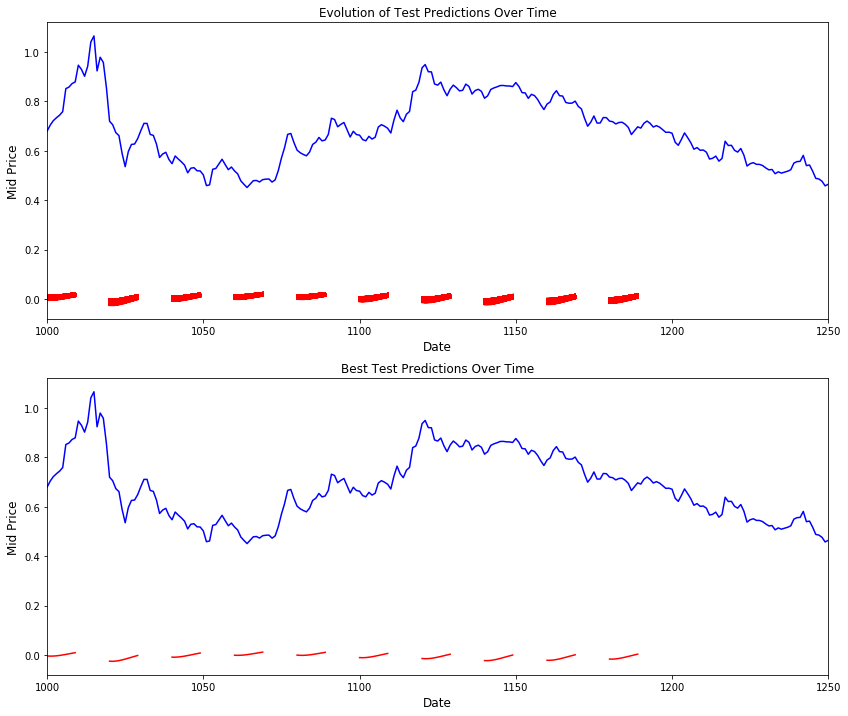

In [25]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (14,12))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/(len(predictions_over_time[::3])+0.01))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Mid Price',fontsize=12)
plt.xlim(1000,1250)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=12)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Mid Price',fontsize=12)
plt.xlim(1000,1250)
plt.show()